# AMPSphere v.2022-03

This is a notebook meant to form the set of notebooks used to analyze the data in AMPSphere and write the manuscript:

__AMPSphere: Global survey of prokaryotic antimicrobial peptides shaping microbiomes__

### GMGC v.1 homolog c_AMPs 

Here, we show how c_AMPs from AMPSphere are aligned to homolog large proteins from GMGC, their features and
distribution.


In [1]:
# import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

In [2]:
# loading data
gmgc = pd.DataFrame()
for record in pd.read_table('data/result_gmgc.m8.xz',
                            header=None,
                            chunksize=1_000_000):
    gmgc = pd.concat([gmgc, record])

gmgc.columns = ['query', 'target', 'evalue',
                'gapopen', 'pident', 'nident', 
                'qstart', 'qend', 'qlen',
                'tstart', 'tend', 'tlen',
                'alnlen', 'raw', 'bits',
                'cigar', 'qseq', 'tseq',
                'qheader', 'theader', 'qaln',
                'taln', 'qframe', 'tframe',
                'mismatch', 'qcov', 'tcov']

In [3]:
# creating some measures
gmgc['pct_start'] = gmgc['tstart'] * 100 / gmgc['tlen']
gmgc['pct_end'] = gmgc['tend'] * 100 / gmgc['tlen']
gmgc['pct_amp'] = (1 + gmgc.qend - gmgc.qstart)*100 / gmgc.qlen

In [4]:
# histogram of pct_start
gmgc = gmgc.sort_values(
    by=['evalue', 'bits', 'pident'],
    ascending=[True, False, False]
)

df = gmgc.groupby('query').head(1)
# df.to_csv('filtered_gmgc_homologs.tsv.gz', sep='\t', header=True, index=None)

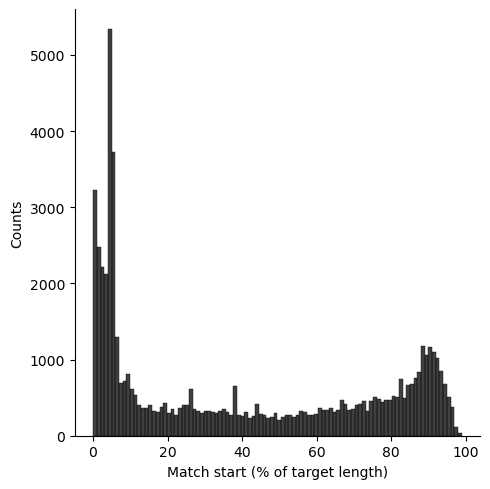

In [5]:
sns.displot(data=df,
            x='pct_start',
            bins=100, 
            color='black')

plt.xlabel('Match start (% of target length)')
plt.ylabel('Counts')
plt.show()

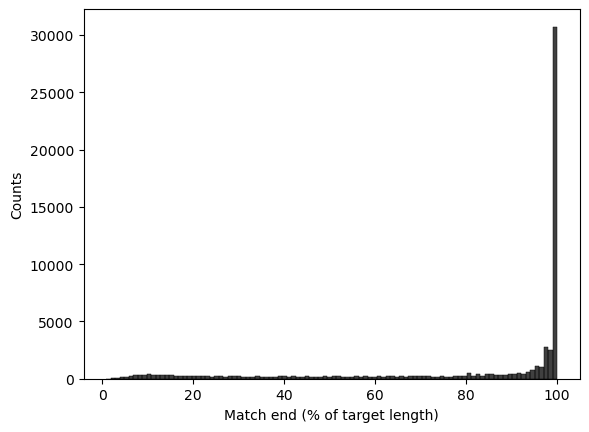

In [6]:
sns.histplot(data=df,
             x='pct_end',
             bins=100, 
             color='black')

plt.xlabel('Match end (% of target length)')
plt.ylabel('Counts')
plt.show()

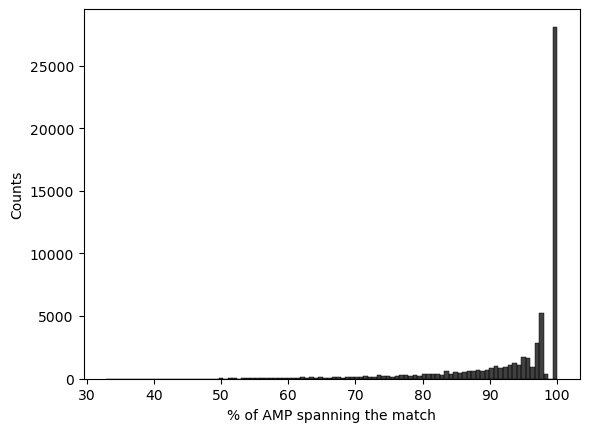

In [7]:
sns.histplot(data=df,
             x='pct_amp',
             bins=100, 
             color='black')

plt.xlabel('% of AMP spanning the match')
plt.ylabel('Counts')
plt.show()

In [8]:
f = df[(df.pct_start <= 25)|(df.pct_start >= 75)]
f = len(f) * 100 / len(df)

print(f'{f:.2}% of hits begin in the initial or final 25% of target protein')

7.3e+01% of hits begin in the initial or final 25% of target protein


### Enrichment of ortholog groups among the homologs

In [9]:
data = pd.read_table('data/adjust_significant_function.csv.xz',
                     sep='\t',
                     header='infer')

data = data.sort_values(by='times')

e5 = pd.read_table('data/e5_annotations.tsv.gz', 
                  sep='\t',
                  header=None)

e5.columns = ['tax', 'eggnog_OG', 'cog_class', 'function']

data = data.merge(on='eggnog_OG', right=e5)
data = data[['eggnog_OG', 'count_AMP', 'cog_class', 'times', 'p_adjust']]
data = data.drop_duplicates()

print(f'It was found {len(data)} OGs in the c_AMP homologs set')
print(f'{len(data[data.p_adjust < 0.05])} OGs were significantly enriched')

It was found 44559 OGs in the c_AMP homologs set
3954 OGs were significantly enriched


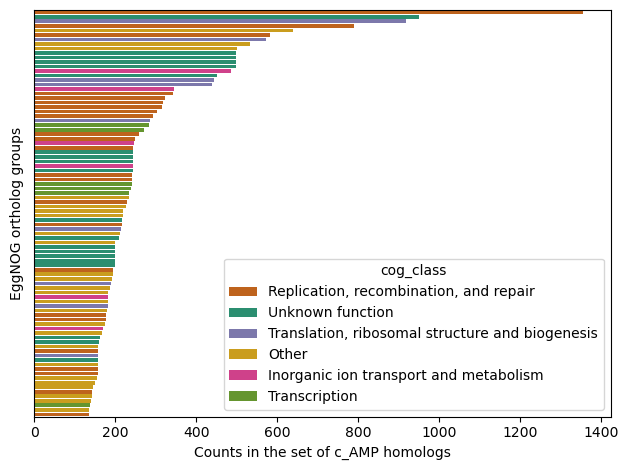

In [10]:
x = data[data.count_AMP >= 100]
x = x.sort_values(by='count_AMP', ascending=False)
x = x.head(100)

topclass = {'S': 'Unknown function',
            'L': 'Replication, recombination, and repair',
            'J': 'Translation, ribosomal structure and biogenesis',
            'P': 'Inorganic ion transport and metabolism',
            'K': 'Transcription'}

color_map = {'Unknown function': '#1B9E77',
             'Replication, recombination, and repair': '#D95F02',
             'Translation, ribosomal structure and biogenesis': '#7570B3',
             'Inorganic ion transport and metabolism': '#E7298A',
             'Transcription': '#66A61E',
             'Other': '#E6AB02'}

x['cog_class'] = [topclass.get(j, 'Other') for j in x.cog_class]

sns.barplot(data=x,
            orient='h',
            x='count_AMP',
            y='eggnog_OG',
            hue='cog_class',
            dodge=False,
            palette=color_map)

plt.yticks([])
plt.xlabel('Counts in the set of c_AMP homologs')
plt.ylabel('EggNOG ortholog groups')
plt.tight_layout()
plt.show()
#plt.savefig('ogs_distribution_top100.svg')

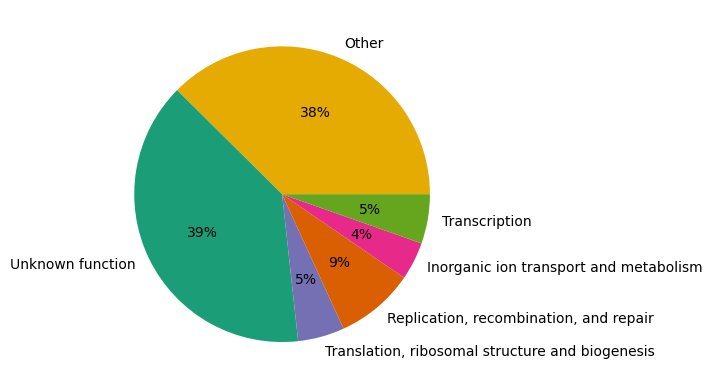

In [11]:
test = Counter([topclass.get(j, 'Other') for j in data.cog_class])

label, dc, cl = [], [], []
for k, v in test.items():
  label.append(k)
  dc.append(v)
  cl.append(color_map.get(k))

plt.pie(dc, labels = label, colors = cl, autopct='%.0f%%')
plt.show()
#plt.savefig('ogs_distribution.svg')

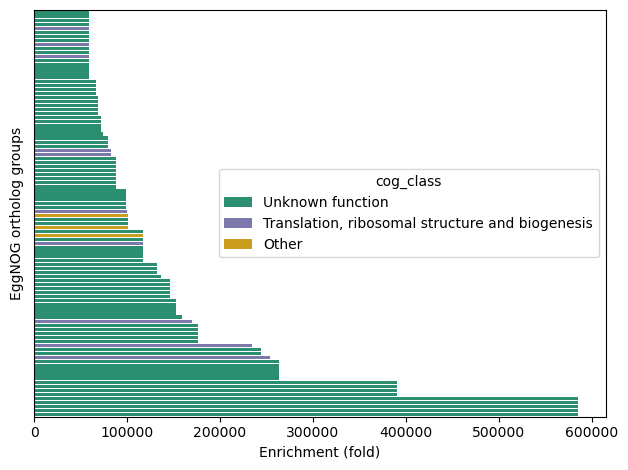

In [12]:
data = data.sort_values(by='times')
x = data.copy()
x = x[x.p_adjust < 0.05]
x = x.tail(100)

x['cog_class'] = [topclass.get(j, 'Other') for j in x.cog_class]

sns.barplot(data=x,
            x='times',
            y='eggnog_OG',
            hue='cog_class',
            orient='h',
            palette=color_map,
            dodge=False)

plt.yticks([])
plt.xlabel('Enrichment (fold)')
plt.ylabel('EggNOG ortholog groups')
plt.tight_layout()
plt.show()
#plt.savefig('enriched_ogs_top100.svg')

/tmp/ipykernel_612859/2064083403.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['cog_class'] = [topclass.get(j, 'Other') for j in test.cog_class]


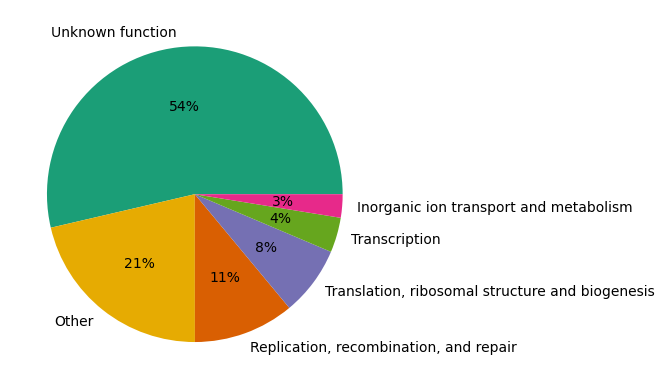

In [13]:
test = data[data.p_adjust < 0.05]
test['cog_class'] = [topclass.get(j, 'Other') for j in test.cog_class]
test = test.cog_class.value_counts()
test = test.to_dict()

label, dc, cl = [], [], []
for k, v in test.items():
  label.append(k)
  dc.append(v)
  cl.append(color_map.get(k))

plt.pie(dc, labels = label, colors = cl, autopct='%.0f%%')
plt.show()
#plt.savefig('enrichment_OGs.svg')